# Assignment 5

## 1.复习课上内容， 阅读相应论文。

## 2. 回答以下理论题目

### 2. 1.  What is autoencoder?

### 自动编码器的本质上是学习输入数据低维特征表示的神经网络结构（下图来源于网络）

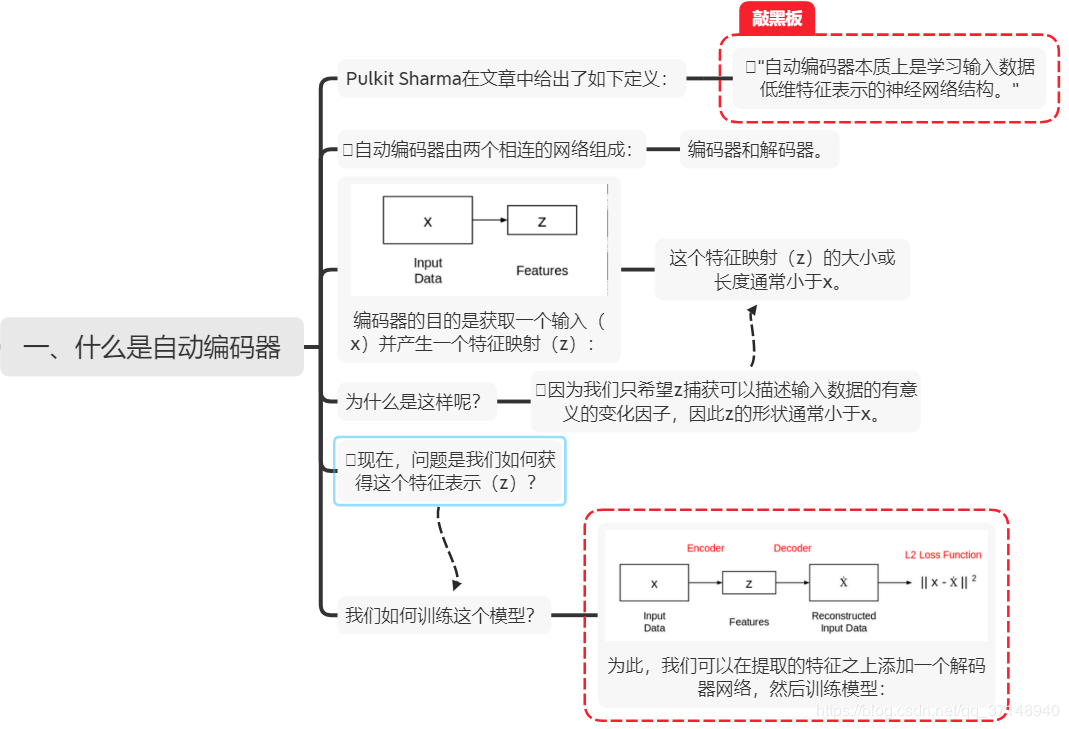

### 2. 2. What are the differences between greedy search and beam search?

### 贪心搜索(greedy search)：贪心搜索最为简单，直接选择每个输出的最大概率，直到出现终结符或最大句子长度。
### 集束搜索(beam search)：集束搜索是一种启发式图搜索算法，在图的解空间比较大的情况下，为了减少搜索所占用的空间和时间，在每一步深度扩展的时候，剪掉一些质量比较差的结点，保留下一些质量较高的结点。
### 不同点：贪婪算法只会挑出最可能的那一个单词，然后继续。而集束搜索则会考虑多个选择

### 2. 3. What is the intuition of attention mechanism?

## 注意机制的直觉是什么?
## Attention Mechanism可以帮助模型对输入的X每个部分赋予不同的权重，抽取出更加关键及重要的信息，使模型做出更加准确的判断，同时不会对模型的计算和存储带来更大的开销

### 2. 4. What is the disadvantage of word embeding introduced in previous lectures ?


## 学习过程相对复杂且受训练语言资料影响很大。

### 2. 5. Briefly describe what is self-attention and what is multi-head attention?

## multi-head attention：让模型从不同表示空间上获取关于句子更多层面的信息, 提高模型的特征表达能力. 同时在现有的词向量和位置向量作为网络输入的基础上, 进一步引入依存句法特征和相对核心谓词依赖特征, 其中依存句法特征包括当前词的依存关系值和所依赖的父节点位置, 从而使模型进一步获取更多的文本句法信息
## self-attention：self-attention是attentio机制的一种，自己对自己的权重，为了充分考虑句子之间不同词语之间的语义及语法联系。

## 3. 中英文自动翻译模型的构建（使用encoder-decoder模型）

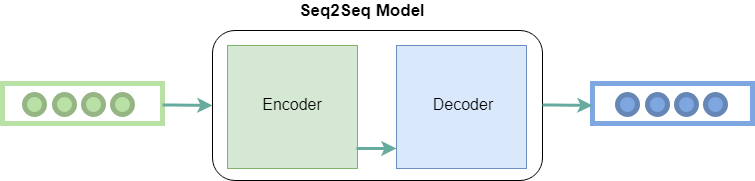

<h3>11.4.1 导入需要的模块及数据</h3>

In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import regex as re
import random
import jieba
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.font_manager as fm
#myfont = fm.FontProperties(fname='/home/wumg/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/simhei.ttf')
#myfont = fm.FontProperties(fname='/Users/Admin/Anaconda3/Lib/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<h3>11.4.2 预处理数据</h3>

In [4]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
    def addSentence_cn(self, sentence):
        for word in list(jieba.cut(sentence)):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [5]:
# 为便于数据处理，把Unicode字符串转换为ASCII编码

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# 对英文转换为小写，去空格及非字母符号等处理

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    #s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [6]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # 读文件，然后分成行
    lines = open('./%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # 把行分成语句对，并进行规范化
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # 判断是否需要转换语句对的次序，如[英文，中文]转换为[中文，英文]次序
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [7]:
#为便于训练，这里选择部分数据
MAX_LENGTH = 20


eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
   # print(p[1].startswith(eng_prefixes))
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [8]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence_cn(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [9]:
input_lang, output_lang, pairs = prepareData('cmn', 'eng',True)
print(random.choice(pairs))

Reading lines...


Building prefix dict from the default dictionary ...


Read 21007 sentence pairs
Trimmed to 640 sentence pairs
Counting words...


Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.896 seconds.
Prefix dict has been built succesfully.


Counted words:
eng 1063
cmn 808
['我對日本歷史有興趣。', 'i am interested in japanese history .']


In [10]:
pairs[:3]

[['我冷。', 'i am cold .'], ['我沒事。', 'i am okay .'], ['我生病了。', 'i am sick .']]

<h3>11.4.3 构建模型</h3>

In [11]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [12]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [13]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [14]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def indexesFromSentence_cn(lang, sentence):
    return [lang.word2index[word] for word in list(jieba.cut(sentence))]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorFromSentence_cn(lang, sentence):
    indexes = indexesFromSentence_cn(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence_cn(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

<h3>11.4.4 训练模型</h3>

In [15]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [16]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [17]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  
    plot_loss_total = 0 

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [19]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence_cn(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [20]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

1m 49s (- 25m 34s) (5000 6%) 2.6591
3m 28s (- 22m 38s) (10000 13%) 1.1300
5m 9s (- 20m 38s) (15000 20%) 0.2214
6m 49s (- 18m 46s) (20000 26%) 0.0477
8m 30s (- 17m 1s) (25000 33%) 0.0270
10m 11s (- 15m 17s) (30000 40%) 0.0218
11m 52s (- 13m 33s) (35000 46%) 0.0197
13m 33s (- 11m 51s) (40000 53%) 0.0154
15m 13s (- 10m 9s) (45000 60%) 0.0143
16m 54s (- 8m 27s) (50000 66%) 0.0145
18m 35s (- 6m 45s) (55000 73%) 0.0133
20m 16s (- 5m 4s) (60000 80%) 0.0150
21m 56s (- 3m 22s) (65000 86%) 0.0119
23m 35s (- 1m 41s) (70000 93%) 0.0121
25m 14s (- 0m 0s) (75000 100%) 0.0112


<Figure size 432x288 with 0 Axes>

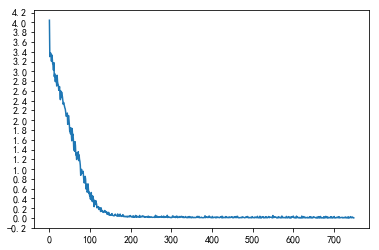

In [21]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

<h3>11.4.5随机采样，对模型进行测试</h3>

In [22]:
evaluateRandomly(encoder1, attn_decoder1)

> 我在考慮出國。
= i am thinking of going abroad .
< i am thinking of going abroad . <EOS>

> 她是女教师。
= she is a teacher .
< she is a teacher . <EOS>

> 我對音樂有興趣。
= i am interested in music .
< i am interested in music . <EOS>

> 你要对结果负责。
= you are responsible for the result .
< you are responsible for the result . <EOS>

> 他總是忘記事情。
= he is always forgetting things .
< he is always forgetting things . <EOS>

> 你不應該離開這個房間。
= you are not to leave this room .
< you are not to leave this room . <EOS>

> 你只是說說而已。
= you are just saying that .
< you are just saying that . <EOS>

> 他全速驾驶着。
= he is driving at top speed .
< he is driving at top speed . <EOS>

> 我厌倦了我的工作。
= i am tired of my work .
< i am tired of my work . <EOS>

> 我是素食主义者。
= i am a vegetarian .
< i am a vegetarian . <EOS>



In [23]:
def evaluate_randomly():
    pair = random.choice(pairs)
    
    output_words, decoder_attn = evaluate(pair[0])
    output_sentence = ' '.join(output_words)
    
    print('>', pair[0])
    print('=', pair[1])
    print('<', output_sentence)
    print('')

In [24]:
def evaluateRandomly(encoder, decoder, n=20):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

<h3>11.4.6可视化注意力</h3>

In [25]:

def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + list(jieba.cut(input_sentence)) +
                       ['<EOS>'], rotation=90,fontproperties=myfont)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

input = 我很幸福。
output = i am very happy . <EOS>


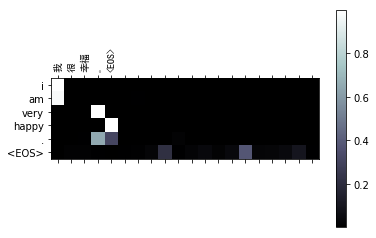

input = 我们在严肃地谈论你的未来。
output = we are having a serious talk about your future . <EOS>


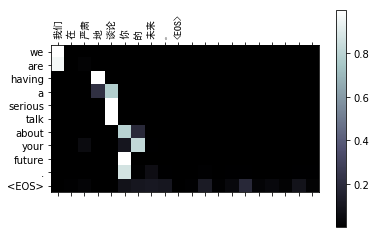

input = 我在家。
output = i am at home . <EOS>


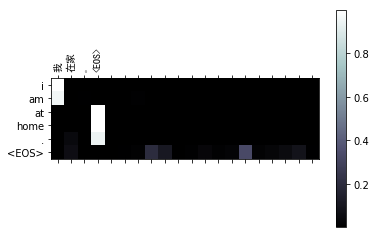

input = 我们在严肃地谈论你的未来。
output = we are having a serious talk about your future . <EOS>


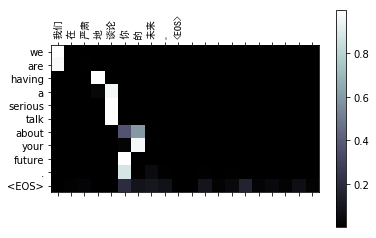

In [52]:
def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("我很幸福。")

evaluateAndShowAttention("我们在严肃地谈论你的未来。")

evaluateAndShowAttention("我在家。")

evaluateAndShowAttention("我们在严肃地谈论你的未来。")